In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv

--2023-10-11 17:24:24--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1475504 (1.4M) [text/plain]
Saving to: ‘data.csv.2’

data.csv.2          100%[===================>]   1.41M  --.-KB/s    in 0.09s   

2023-10-11 17:24:24 (16.4 MB/s) - ‘data.csv.2’ saved [1475504/1475504]



In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [3]:
# Load data
df = pd.read_csv('data.csv')
# Only keep these column
df = df[['Make', 'Model', 'Year', 'Engine HP', 'Engine Cylinders',
         'Transmission Type', 'Vehicle Style', 'highway MPG', 'city mpg',
         'MSRP']]
df.columns = df.columns.str.replace(' ', '_').str.lower()
# Replace NaN values with 0
df.fillna(0, inplace=True)
# Rename mrsp: price
df.rename(columns={'msrp': 'price'}, inplace=True)
# Make variable named above_average
avg = np.mean(df['price'])
df['above_average'] = (df['price'] > avg).astype(int)

#
X = df.drop(['price', "above_average"], axis=1)
y = df['above_average']
print(X.columns)

Index(['make', 'model', 'year', 'engine_hp', 'engine_cylinders',
       'transmission_type', 'vehicle_style', 'highway_mpg', 'city_mpg'],
      dtype='object')


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               11914 non-null  object 
 1   model              11914 non-null  object 
 2   year               11914 non-null  int64  
 3   engine_hp          11914 non-null  float64
 4   engine_cylinders   11914 non-null  float64
 5   transmission_type  11914 non-null  object 
 6   vehicle_style      11914 non-null  object 
 7   highway_mpg        11914 non-null  int64  
 8   city_mpg           11914 non-null  int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 837.8+ KB


In [6]:
X.columns

Index(['make', 'model', 'year', 'engine_hp', 'engine_cylinders',
       'transmission_type', 'vehicle_style', 'highway_mpg', 'city_mpg'],
      dtype='object')

In [7]:
numerical = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']
auc_dct = {}
for item in numerical:
  fpr, tpr, thresholds = metrics.roc_curve(X_train[item], y_train, pos_label=2)
  result = metrics.auc(fpr, tpr)
  auc_dct.update({item: result})

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


In [8]:
auc_scores = []
numerical = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']
auc_dct = {}
for variable in numerical:
    auc = roc_auc_score(y_train, X_train[variable])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -X_train[variable])
    auc_scores.append(auc)

In [9]:
highest_auc_variable = numerical[auc_scores.index(max(auc_scores))]
for i, variable in enumerate(numerical):
    print(f"{variable}: {auc_scores[i]}")

engine_hp: 0.9171031265539011
engine_cylinders: 0.766116490165669
highway_mpg: 0.6330587871772013
city_mpg: 0.6734244643245233


In [10]:
def onehot_encode(dataset):
  '''
  **Params:
  dataset: loading the dataset name
  -----------------------
  **Return:
  return dataset after apply one hot encoding
  '''
  categorical = ["make", "model", "transmission_type", "vehicle_style"]
  numerical = ["year", "engine_hp", "engine_cylinders", "highway_mpg", "city_mpg"]
  train_dicts = dataset[categorical + numerical].to_dict(orient='records')
  dv = DictVectorizer(sparse=False)
  X = dv.fit_transform(train_dicts)
  feature_name = dv.get_feature_names_out()
  return X, feature_name

In [11]:
X, name = onehot_encode(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [12]:
y_pred = model.predict(X_val)
round(accuracy_score(y_pred, y_val),3)

0.935

In [13]:
report = classification_report(y_val, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1729
           1       0.89      0.87      0.88       654

    accuracy                           0.93      2383
   macro avg       0.92      0.91      0.92      2383
weighted avg       0.93      0.93      0.93      2383



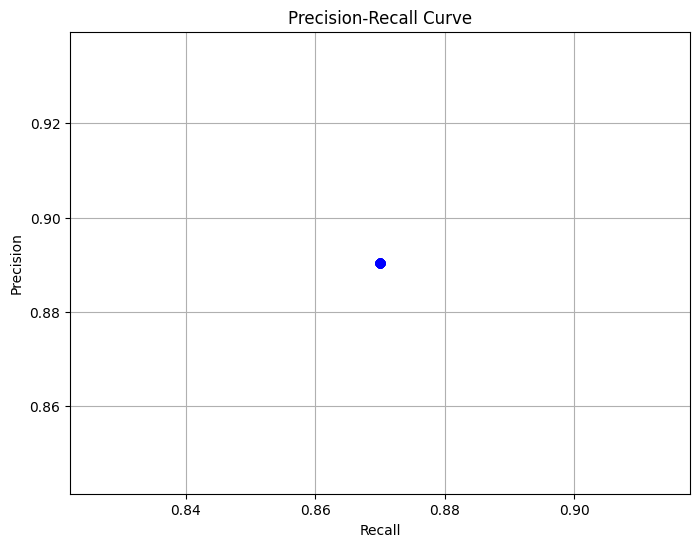

In [14]:
thresholds = np.arange(0, 1.01, 0.01)
precisions = []
recalls = []
f1 = []
for threshold in thresholds:
  #predicted_labels = [1 if score >= threshold else 0 for score in y_pred]
  precision = precision_score(y_val, y_pred)
  recall = recall_score(y_val, y_pred)
  f1_s = f1_score(y_val, y_pred)
  precisions.append(precision)
  recalls.append(recall)
  f1.append(f1_s)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, marker='o', linestyle='-', color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)

In [15]:
max_value = max(f1)  # Find the maximum value
max_index = f1.index(max_value)
print(thresholds[max_index])

0.0


In [23]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
X = df.drop(['price', "above_average"], axis=1)
y = df['above_average']
X, name = onehot_encode(X)

def train_model(X,y, C_num=1.0):
  acc_lst = []
  for train_idx, val_idx in kfold.split(X):
    X_train = X[train_idx]
    X_val = X[val_idx]

    y_train = y[train_idx]
    y_val = y[val_idx]

    model = LogisticRegression(solver='liblinear', C=C_num, max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    result = round(accuracy_score(y_pred, y_val),3)
    acc_lst.append(result)

  return acc_lst


In [24]:
lst = train_model(X,y)
np.std(lst)

0.006406246951218759

In [25]:
C_lst = [0.01, 0.1, 0.5, 10]
grid_dct = {}
for item in C_lst:
  kq_lst = train_model(X, y, C_num=item)
  std = np.std(kq_lst)
  mean = np.mean(kq_lst)
  kq = [mean, std]
  grid_dct.update({item: kq})



In [26]:
grid_dct

{0.01: [0.8934000000000001, 0.004923413450036473],
 0.1: [0.9192000000000002, 0.003867815921162747],
 0.5: [0.9292, 0.00856504524214555],
 10: [0.9278000000000001, 0.0062417946137309]}